# **STAGE PONTS INSTRUMENTES - Notebook 4 Partie 1**

## Table of Contents

### 0. [Bibliothèques](#0/-Biblitohèques)
### I. [Chargement de la data](#I/-Chargement-de-la-data)
### II. [Normalisation de l'échelle des signaux par interpolation signal/mètre](#II/-Normalisation-de-l'échelle-des-signaux-par-interpolation-signal/mètre)
1. [Fonction d'interpolation](#II.1-Fonction-d'interpolation)
2. [Préparation des matrices](#II.2-Préparation-des-arrays-T-tile-et-Y-tilde-pour-plusieurs-camions)
3. [Test sur la reconstruction d'un signal](#II.3-Test-sur-la-reconstruction-d'un-signal-d'un-camion-de-calibration)
4. [Calcul de la ligne d'influence](#II.4-Calcul-de-la-ligne-d'influence)

### III. [Reconstruction](#III/-Reconstruction)

### IV. [Visualisation](#IV/-Visualisation)



**Dans ce Notebook, nous allons normaliser l'échelle des signaux mesurés pour nos camions de calibration. Cette solution permettrait d'être indépendant de leurs vitesses dans la suite des calculs**

## 0/ Biblitohèques

In [1]:
from Bwifsttar import load_senlis_modified

## I/ Chargement de la data

In [2]:
calibration_trucks,traffic_trucks = load_senlis_modified(6)

## II/ Normalisation de l'échelle des signaux par interpolation signal/mètre

### II.1 Fonction d'interpolation

**Ici, nous interpolons le signal du camion pris en paramètre avec la liste meters associée. Cela permet de reconstruire par la suite le signal sur la fenêtre que nous voulons.**

In [3]:
def normalize(truck):
    """
        Données :
            - truck : namedTuple Truck dont nous voulons interpoler le signal
        Sorties :
            - new_signal : nouveau signal reconstruit sur l'intervalle [0,L] par interpolation du signal avec les mètres
            - new_meters : nouvel intervalle [0,L] utilisé pour générer new_signal
            - new_peaks : peaks correspondant à la nouvelle échelle (new_meters)
        Fonction : Retourne pour un camion son signal reconstruit sur un nouvel intervalle, avec cet intervalle
        et les nouvelles positions des peaks.

    """
    from scipy.interpolate import interp1d
    import numpy as np
    from Bwifsttar import locate_peaks
    
    meters = truck.speed * truck.time
    meters = meters - meters[truck.peaks[0]]
    signal = truck.signals
    func = interp1d(meters, signal, fill_value="extrapolate")
    new_meters = np.arange(meters.min(), meters.max(), 0.02)
    new_signal = func(new_meters)
    new_peaks  = locate_peaks(new_signal)

    return new_signal,new_meters,new_peaks

### II.2 Préparation des arrays T-tile et Y-tilde pour plusieurs camions

**Il suffit ensuite de recréer les signaux avec la fonction ci-dessus si les camions de l'ensemble calibration n'ont pas tous la même vitesse**

In [6]:
def prepare_least_squares_mt_norm1(trucks,length):
    """
        Données : 
            - trucks : Liste des namedTuples truck 
            - length : Longueur de la ligne d'influence (classiquement fixée à 701)
        Sorties :
            - As2 : Liste des T (somme Teoplitz*poids) définis ci-dessus (ou T tilde)
            - bs : Liste des signaux (ou y tilde)
        
        Fonction : Retourne T-tilde et y-tilde, servant par la suite pour la calibration, à partir
        de la liste des camions de calibration et la longueur de la ligne d'influence (LI). Normalise
        l'échelle des signaux si les camions de l'ensemble ont des vitesses différentes.
    
    """
    import numpy as np
    from Previous_files.bwim import create_toeplitz
    
    trucks_calculables = [truck for truck in trucks if(len(truck.weights) == len(truck.peaks))]#Garde les camions dont les poids ont chacun un peaks sur le signal
    
    #On créee le boléen qui nous permettra de savoir s'il faut normaliser ou non
    must_be_normalized = False
    
    #On lui affecte une valeur (True si dans l'ensemble de camions il y a des vitesses différentes. False sinon)
    speed_0= trucks_calculables[0].speed
    for truck in trucks_calculables :
        if truck.speed != speed_0:
            must_be_normalized = 1
    
    #on initialise y_tilde (signaux des camions de calibration) et T_tilde (concaténation des matrices T = somme des wa.Da)
    T_tilde = np.empty(len(trucks_calculables),dtype=object) #car nous stockons des matrices de tailles différentes
    y_tilde = np.empty(len(trucks_calculables),dtype=object) 
  
    for i,truck in enumerate(trucks_calculables):

        if must_be_normalized:
            signals,_,peaks = normalize(truck)
        else:
            signals = truck.signals
            peaks = truck.peaks
        shape = signals.shape #prend les dimensions du signal du camion (y)
        toeplitz = create_toeplitz(shape[-1], length, peaks) #Da 

        T = np.sum(truck.weights[:,None,None] * toeplitz, axis=0)# T = Somme des wa*Da 
        y = signals # y (le signal)
        if len(shape) == 2:
            T = np.tile(T, reps=(shape[0],1))
            y = np.concatenate(y)
            
        T = T.astype(float)
        T_tilde[i] = T
        y_tilde[i] = y
        
    return T_tilde, y_tilde # retourne le signal et A (correspondants à y et T dans les notebooks)


### II.3 Test sur la reconstruction d'un signal d'un camion de calibration

Nombre de camions :  12
shape T_tilde :  (11,)
shape y_tilde :  (11,)
T_tilde[0] :  (1877, 701)
y_tilde[0] :  (1877,)


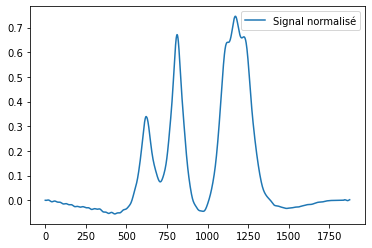

In [7]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
print("Nombre de camions : ",len(calibration_trucks))
truck = calibration_trucks[0]

T_tilde,y_tilde= prepare_least_squares_mt_norm1(calibration_trucks,701)
print("shape T_tilde : ",T_tilde.shape)
print("shape y_tilde : ",y_tilde.shape)
print("T_tilde[0] : ",T_tilde[0].shape)
print("y_tilde[0] : ",y_tilde[0].shape)
#print((As[0]))
#print(Bs[0])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(y_tilde[0],label='Signal normalisé')
plt.legend()
plt.show()

### II.4 Calcul de la ligne d'influence

In [8]:
def calibration_mt_norm1(trucks, l2_reg=None, tv_reg=None):# pour le moment aucune régularization
    """
        Données :
            - trucks : liste des camions de calibration
            - l2_reg : Régularisation L2
            - tv_reg : Régularisation Totale Variance
        Sorties :
            - influence_finale.x : Ligne d'influence estimée à partir des camions de calibration
        Fonction : Calcul la ligne d'influence à partir d'une liste de camions. Normalise l'échelle
        des signaux si les camions n'ont pas les mêmes vitesses.
    """
    import numpy as np
    from Bwifsttar import get_std
    from scipy.optimize import minimize

    #Préparation des matrices utiles à la minimisation
    
    T_tilde, y_tilde = prepare_least_squares_mt_norm1(trucks,800)
    
    for T in T_tilde:
        T = T.astype(float)
        
    for y in y_tilde:
        y = y.astype(float)

    trucks_calculables = [truck for truck in trucks if(len(truck.weights) == len(truck.peaks))]
    
    #Coeffs de pondération par niveau de bruit
    
    ws = np.array([])
    for truck in trucks_calculables:
        ws=np.append(ws,1/get_std(truck))
    ws = 0.001*ws
    
    #Définition de la ligne d'influence 0 (pour commencer le calcul)
    
    infl0,_, _, _ = np.linalg.lstsq(T_tilde[0],y_tilde[0], rcond=None)  
   
    #Définition de la fonction à minimiser 
    def func_finale_to_min(h):
        """
            Données : 
                - h : la ligne d'influence (que nous cherchons par la minimisation)
            Sorties :
                - sum_to_minimize : Somme des moindres carrés à minimiser
            Fonction :
                Prend en paramètre la LI et retourne la somme à minimiser
        """
        norm_array = np.array([])
        for i in range(T_tilde.shape[0]):
            #norm_array = np.append(norm_array,func_to_min(h,i))
            norm_array = np.append(norm_array,ws[i]*np.linalg.norm(T_tilde[i]@h-y_tilde[i])**2)
            
        sum_to_minimize = np.sum(norm_array)
        return sum_to_minimize
    

    influence_finale = minimize(func_finale_to_min,infl0,method='Nelder-Mead',tol=0.1)#utiliser CG pour plus rapidité
    
    return influence_finale.x

In [9]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
inf = calibration_mt_norm1(calibration_trucks[0:2])
print(inf.shape)



(800,)


## III/ Reconstruction


In [10]:
def time_to_meter_conversion_mt_norm1(time, signals, speed, peaks, delta=0.02):
    """
        Données :
            - time : Liste des temps captés pour le camion
            - signals : signal du camion
            - speed : vitesse du camion
            - peaks : emplacements des peaks du camion
            - delta : écart entre deux points de reconstruction
        Sorties :
            - grid : Nouvelle liste des mètres
            - le nouveau signal
        Fonction : interpole le signal 
    """
    import numpy as np
    from scipy.interpolate import interp1d
    meters = speed * time
    meters = meters - meters[peaks[0]]
    grid = np.arange(meters.min(), meters.max(), delta)
    new_signals = []
    for s in np.atleast_2d(signals):
        func = interp1d(meters, s, fill_value="extrapolate")
        new_s = func(grid)
        new_signals.append(new_s)
    return grid, np.array(new_signals).squeeze()

In [11]:
def time_to_meter_interpolation_mt_norm1(truck, influence): 
    """
        Données :
            - truck : namedTuple Truck
            - influence : Ligne d'influence
        Sorties :
            - func : fonction interpolée LI/mètres
            - dist : Distance maximale de la liste meters
        Fonction : interpole la LI par rapport aux mètres
    
    """
    import numpy as np
    from scipy.interpolate import interp1d
    
    meters = np.linspace(0, 30, len(influence))
    dist   = meters.max()
    func   = interp1d(meters[:len(influence)], influence, fill_value="extrapolate")#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)
    return func, dist#retourne la distance totale et la fonction d'interpolation

In [12]:
def time_to_meter_sampling_mt_norm1(truck, influence):
    
    """
        Données :
            - truck : camion (type namedTuple)
            - influence : Ligne d'influence 
        Sortie :
            - func(meters) : Ligne d'influence estimée sur le vecteur meters 
        Fonction : Retourne la ligne d'influence adaptée aux meters du camion pris en paramètre
    """
    import numpy as np
    func, dist = time_to_meter_interpolation_mt_norm1(truck, influence)
    #meters = truck.speed * truck.time
    meters = np.linspace(0, 30,810)
    meters = meters[meters<=dist]
    return func(meters)#donne les valeurs via fonction d'interpolation des 'influence' (temps) pour une distance maximum

def reconstruction_norm1(truck, influence_bundle):
    """
        Données : 
            - truck : type namedTuple Truck
            - influence_bundle : influence donnée
        Sortie :
            - predicted : signal reconstruit
            - influence : ligne d'influence adaptée aux meters du camion pris en paramètre
    """
    import numpy as np
    from Previous_files.bwim import create_toeplitz

    influence = time_to_meter_sampling_mt_norm1(truck, influence_bundle)
    toeplitz  = create_toeplitz(truck.time.size, influence.size, truck.peaks)
    T_matrix  = np.sum(truck.weights[:,None,None] * toeplitz, axis=0)
    predicted = T_matrix @ influence
    return predicted, influence

In [13]:
def show_calibration_norm1(trucks, influence):
    """
        Données :
            - trucks : Liste de namedTuple Truck
            - influence : Ligne d'influence
        Sorties :
            Void
        Fonction : Affiche les signaux reconstruits et les signaux réels pour chaque truck de la liste trucks
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    trucks_calculables = [truck for truck in trucks if(len(truck.weights) == len(truck.peaks))]

    fig, axs = plt.subplots(3, 4,figsize=(17, 6))
    axs = axs.ravel()
    
    for i,truck in enumerate(trucks_calculables):   
        reconstructed, rescaled = reconstruction_norm1(truck, influence)
        meters = truck.speed * truck.time
        plt.axhline(0, color='k', linewidth=1, zorder=0, alpha=0.1)
        plt.xlabel('Meters')
        axs[i].plot(meters, reconstructed, linewidth=2, label='Recon.')
        axs[i].plot(meters, truck.signals.T, label='Observed', alpha=0.7)
        axs[i].set_title(str("Meters"))

    plt.figure()
    plt.plot(meters[:len(rescaled)], rescaled)
    plt.xlabel("Meters")
    plt.title("Ligne d'nfluence")
    plt.show()

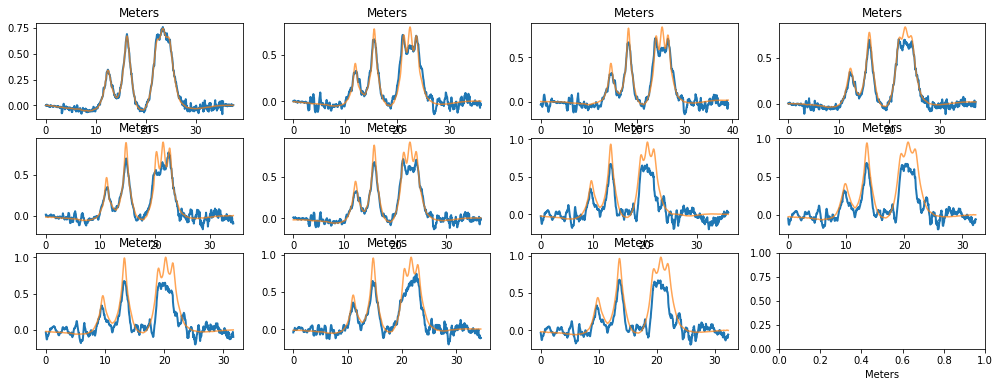

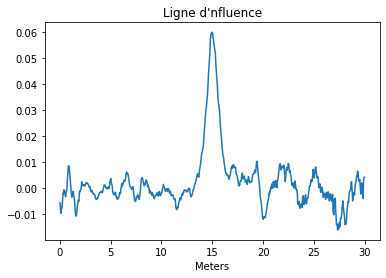

In [14]:


#show_signal(another_truck)
show_calibration_norm1(calibration_trucks, inf)


## IV/ Visualisation

In [15]:
#capteurs = [3,4,6,7]
def lignes_influence_mt_norm1(capteurs,nbre_camions):
    
    """
        Données : 
            - capteurs : chiffre appartenant à [3,4,6,7] identifiant un capteur
            - nbre_camions : nombre de camions sur lesquels faire les calculs de la LI
        Sorties :
            - Hc : Liste des lignes d'influence par capteur
        Fonction : Retourne la liste des lignes d'influence par capteur
    
    """
    import numpy as np
    from Bwifsttar import load_senlis_modified
    Hc = np.empty(len(capteurs),dtype=object)#liste des lignes d'influence (autant que de capteurs à tester)
        
    for i,capteur in enumerate(capteurs):
        calibration_trucks,traffic_trucks = load_senlis_modified(selected=capteur) #[3,4,6,7]
        
        if(nbre_camions<=len(calibration_trucks)):
            
            calibration_trucks = calibration_trucks[0:nbre_camions]
            h = calibration_mt_norm1(calibration_trucks)
            Hc[i] = h
        
        else:
            print("Nombre de camions doit être inférieur ou égal à : ",len(calibration_trucks))
        
        
    return Hc


capteurs = [3,4,6,7] #on remarque que les signaux sur le capteur 3 sont quasi tous nuls
Hc_6 = lignes_influence_mt_norm1(capteurs,12)
print(Hc_6.shape)




(4,)


Capteur :  3


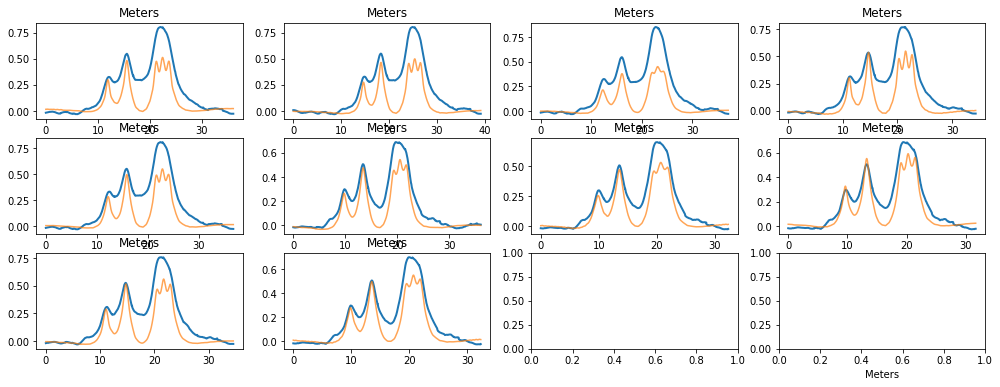

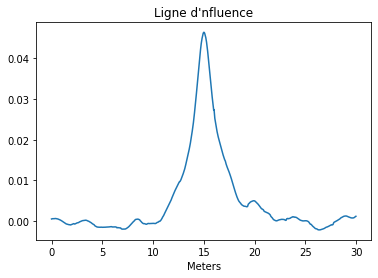

Capteur :  4


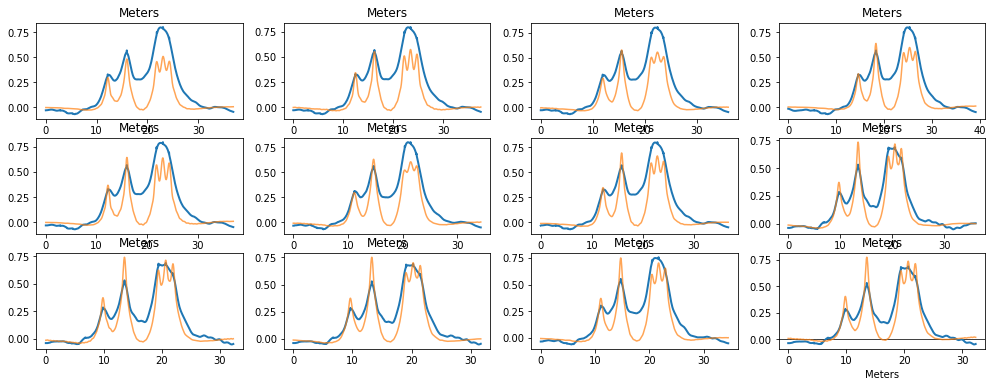

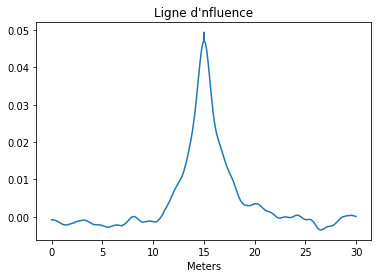

Capteur :  6


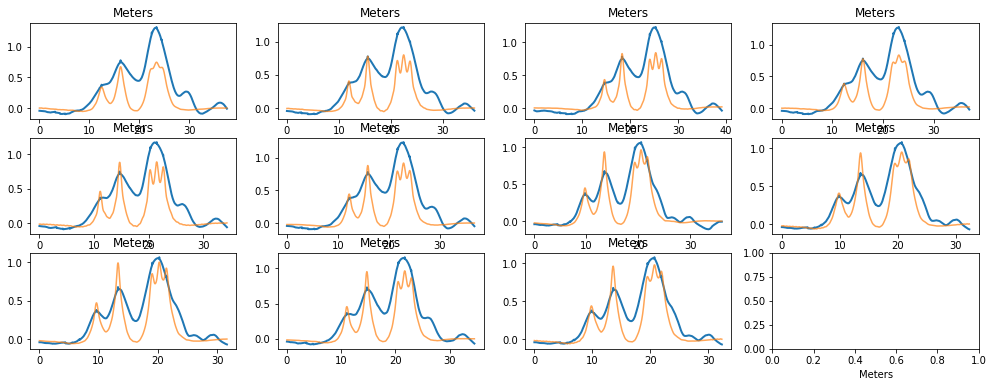

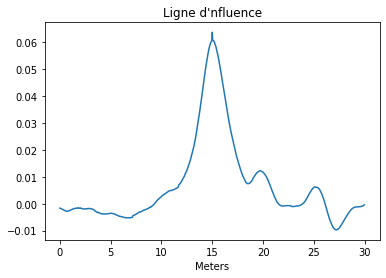

Capteur :  7


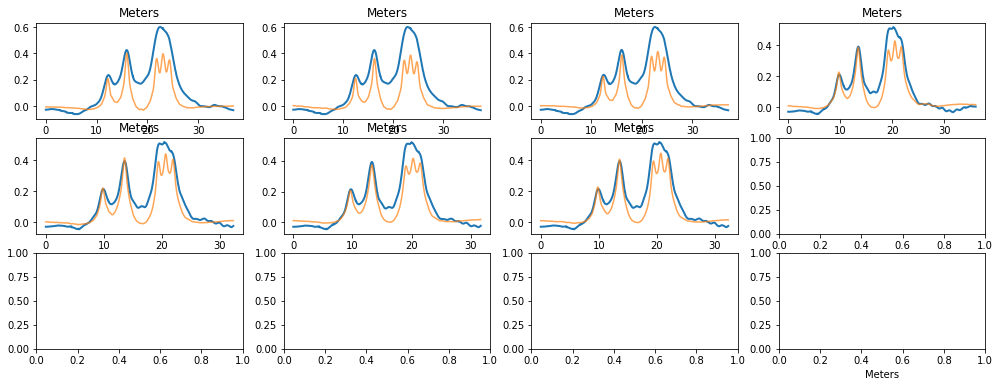

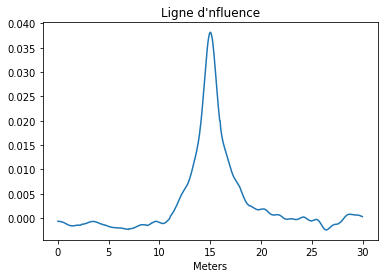

In [16]:
def multi_viz_norm1(Hs,capteurs):
    for i in range(len(Hs)):
        try:
            print("Capteur : ",capteurs[i])
            

            calibration_trucks,traffic_trucks = load_senlis_modified(selected=capteurs[i]) #[3,4,6,7]
            show_calibration_norm1(calibration_trucks, Hc_6[i])

        except:
            print("Echec capteur n° : ",capteurs[i])
            continue
multi_viz_norm1(Hc_6,capteurs)
        